## For Visual Category Data (imgclust)

pickle file: fitted_model_object3.pkl

numstarts = 10

number of time bins = 3

pi_off = 15000.

delta = 1e-4

fr_shape_rate = 1e-4 * np.ones(K)

time_natural = False

od natural prior shape = [1.01, 1.01, 1.01]

od natural prior rate  = [.01, .01, .01] to make the mode = 1

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import cPickle as pickle
from spiketopics.helpers import *

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline
sns.set_style('darkgrid')
savefigs = False

# Load in data

In [2]:
infile = 'fitted_model_object3.pkl'

bins = 3
bin_stim = 1
dt = 900 / bins

Nu = 56
Nstim = 96

with open(infile, 'rb') as f:
    gpm = pickle.load(f)

In [3]:
df = pd.read_csv('data/prepped_data{}.csv'.format(str(bins)))
df.head()

,trial,unit,count,category,time
0,69,0,2,Baseline,0
1,69,1,1,Baseline,0
2,69,2,2,Baseline,0
3,69,3,0,Baseline,0
4,69,4,3,Baseline,0


In [4]:
dfm = df.groupby(['time', 'unit']).mean()['count'].unstack(level=0)

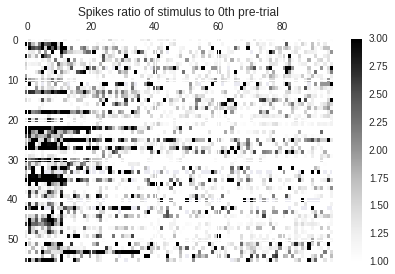

In [5]:
# plot the spikes ratio of stimulus to the time bins before stimulus
for i in range(bin_stim):
    plt.matshow(dfm.values[:, bin_stim::bins] / dfm.values[:, i::bins], 
            aspect='auto', vmin=1, vmax=3)
    plt.colorbar();
    plt.title('Spikes ratio of stimulus to {}th pre-trial'.format(str(i)), y=1.08)


<Container object of 3 artists>

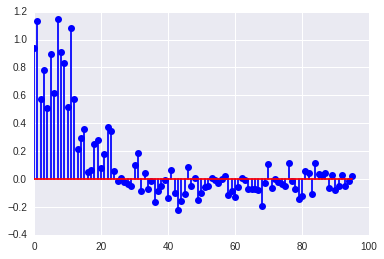

In [6]:
# plot the stimulus ratio
dfmm = df.groupby('time').mean()['count']
dfrel = (dfmm.values[bin_stim::bins] - dfmm.values[::bins])/dfmm.values[::bins]
plt.stem(range(len(dfrel)), dfrel)

In [7]:
gpm.Nframe.head()

,unit,time,trial,count,lam0,lam1
0,0,0,69,2,-1.834691,-1.838332
1,1,0,69,1,-1.361830,-1.433662
2,2,0,69,2,-0.932846,-0.963414
3,3,0,69,0,-0.228471,-0.229261
4,4,0,69,3,-1.392280,-1.356628


In [8]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [9]:
xi = gpm.nodes['HMM'].nodes['z'].z[1].copy()
T, K = xi.shape
print xi.shape

(288, 10)


In [10]:
print 'overdispersion: ' + str(gpm.nodes['overdispersion'].prior_shape)

overdispersion: [ 1.01  1.01  1.01 ...,  1.01  1.01  1.01]


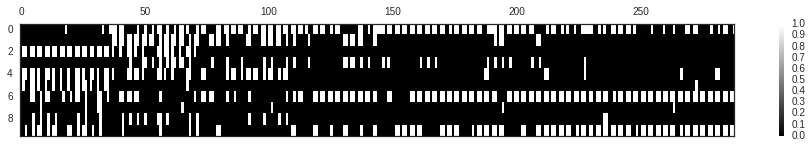

In [11]:
# states of z
matshow(xi.T, vmin=0, vmax=1);
plt.colorbar();

Every third timestep is a different stimulus. Each stimulus has
1. pre-trial baseline
1. stimulus presentation
1. post-stimulus period

So let's plot these individually:

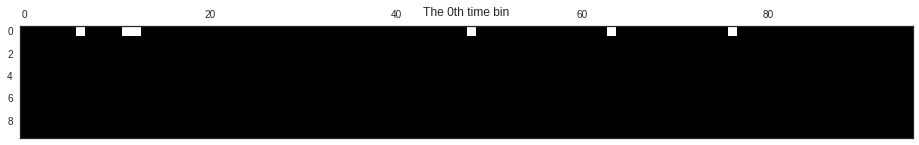

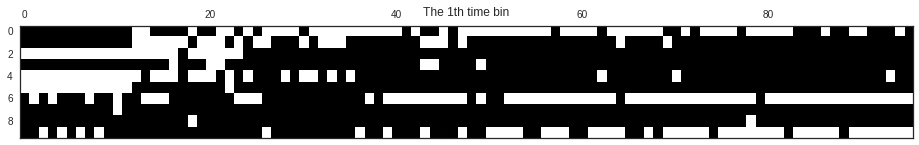

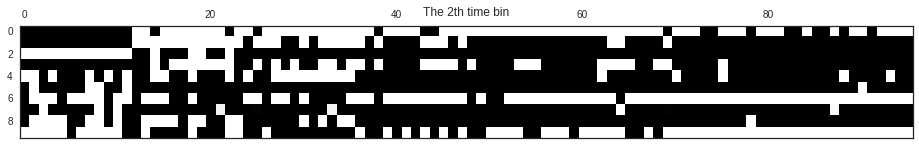

In [12]:
for i in range(bins):

    matshow(xi[i::bins].T, vmin=0, vmax=1)
    plt.title('The {}th time bin'.format(str(i)))

In [13]:
# make a normalizer so we can set the colormap midpoint
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_invalid(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=1., vmin=0.7, vmax=1.3)
cmap = plt.cm.RdBu_r
cmap.set_bad(color='k', alpha=1.0)

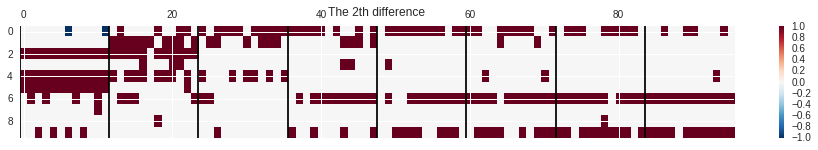

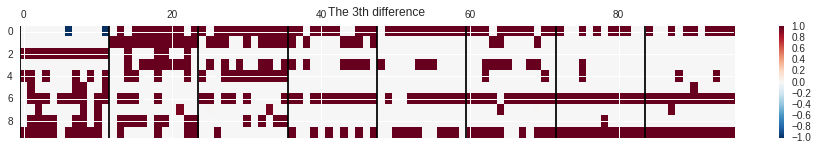

In [14]:
for i in range(1, bins):
    plt.matshow(xi[i::bins].T - xi[::bins].T, vmin=-1, vmax=1, aspect='auto', cmap=cmap)
    plt.colorbar()
    plt.title('The {}th difference'.format(str(i+1)))
    for ind in range(0, xi.shape[0] // bins, 12):
        plt.axvline(ind - 0.5, 0, xi.shape[-1], color='black')

## Generate samples from inferred states

To recover the firing rate w.r.t each neuron regarding 96 stimuli from our model

In [15]:
snames = ['sig057a','sig065a','sig065b','sig066a','sig068a','sig068b','sig069a','sig070a','sig070b','sig072a',
'sig073a','sig074a','sig074b','sig078a','sig080a','sig081a','sig082a','sig082b','sig083a','sig085a','sig086a',
'sig086b','sig087a','sig088a','sig089a','sig091a','sig092a','sig094a','sig095a','sig096a','sig097a','sig100a',
'sig101a','sig101b','sig102a','sig105a','sig108a','sig112a','sig113a','sig113b','sig114a','sig115a','sig116a',
'sig117a','sig117b','sig118a','sig119a','sig121a','sig122a','sig122b','sig125a','sig126a','sig126b','sig127a',
'sig128a','sig128b']

In [16]:
# params for lambda0
lambda0_rate = gpm.nodes['baseline'].post_rate
lambda0_shape = gpm.nodes['baseline'].post_shape

# generate lambda0
lambda0 = []
lambda0 = np.random.gamma(lambda0_shape, scale = 1./lambda0_rate)

# params for lambdauk
lambdauk_shape = gpm.nodes['fr_latents'].post_shape
lambdauk_rate = gpm.nodes['fr_latents'].post_rate

# generate lambdauk
lambdauk = []
lambdauk = np.random.gamma(lambdauk_shape, scale=1./lambdauk_rate)


In [17]:
# generate ztk for each feature and stimuli
xi_stim = xi[bin_stim::bins]
ztk = []
for unit in range(xi_stim.shape[0]):
    for kk in range(xi_stim.shape[1]):
        ztk.append(np.random.binomial(1, xi_stim[unit, kk]))
ztk = np.array(ztk).reshape(Nstim, 10)

In [18]:
# generate samples from posterior parameters
allsamp = np.empty((Nu, Nstim, 0), float)

for ind in range(1000):
    # initialize all prods for 10 features
    allprod = 1
    # initial condition
    lambda0 = []
    lambda0 = np.random.gamma(lambda0_shape, scale = 1./lambda0_rate)
    # generate lambdauk
    lambdauk = []
    lambdauk = np.random.gamma(lambdauk_shape, scale=1./lambdauk_rate)
    
    # multiply over 10 features
    for kk in range(10):
        temprod = lambdauk[:, kk] ** ztk[0, kk]
        for tt in range(1, ztk.shape[0]):
            temprod = np.vstack((temprod, lambdauk[:, kk] ** ztk[tt, kk]))
        allprod = allprod * temprod
    allprod *= lambda0
    
    allsamp = np.append(allsamp, np.expand_dims(allprod.T, axis=-1), axis=-1)


In [19]:
# store stats for all simulations
allstats = np.empty((0, Nstim, 3), float)

for unit in range(Nu):
    
    stats_mat = np.empty((0,3), float)
    
    for stim in range(Nstim):
        counts = allsamp[unit, stim, :] * dt
        lower = np.percentile(counts, 2.5)
        upper = np.percentile(counts, 97.5)
        stats_mat = np.vstack((stats_mat, [counts.mean(), lower, upper]))
    
    allstats = np.append(allstats, np.expand_dims(stats_mat, axis=0), axis=0)

In [20]:
savefig = False

/home/xinchen/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


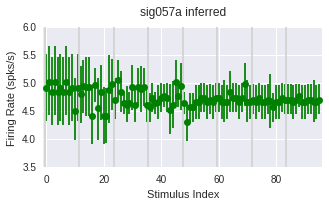

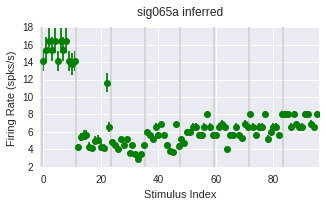

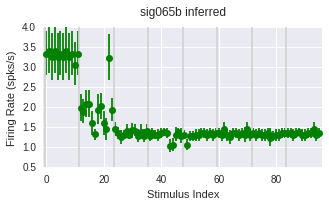

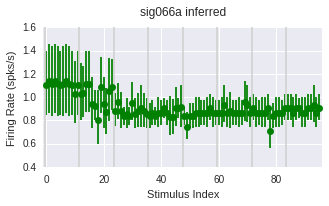

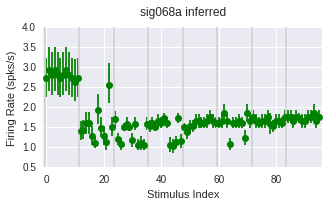

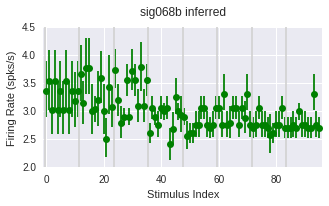

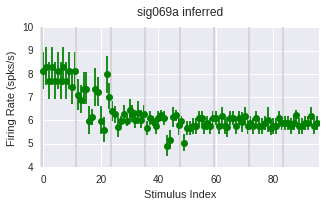

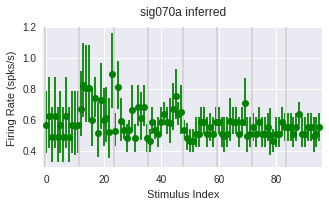

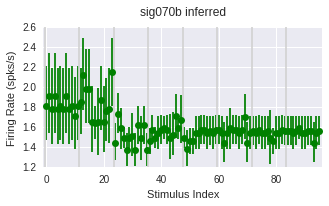

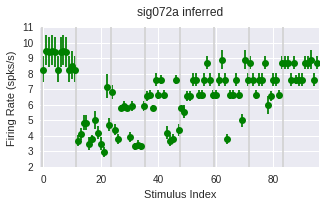

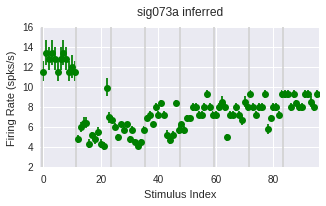

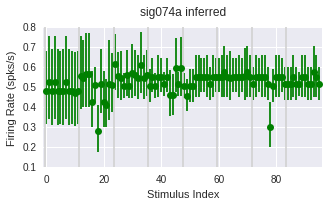

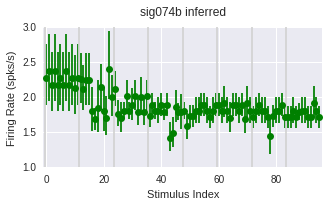

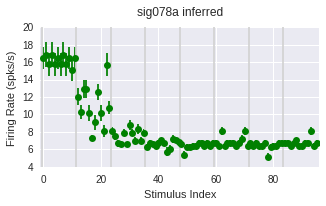

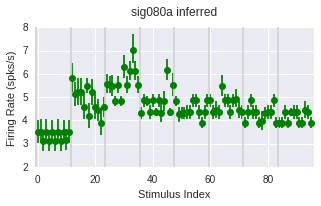

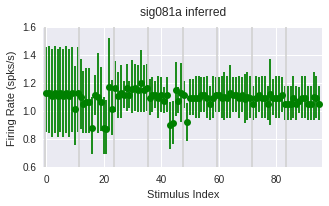

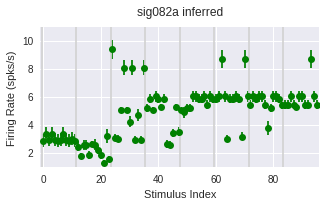

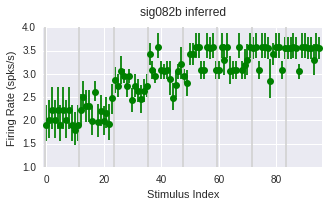

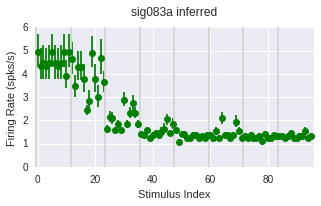

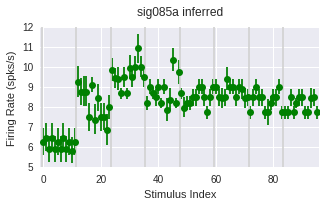

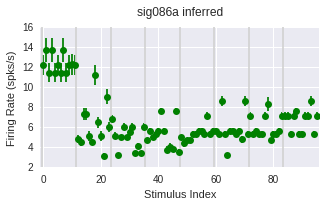

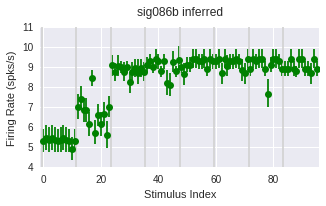

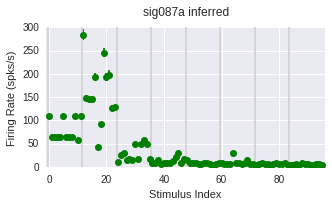

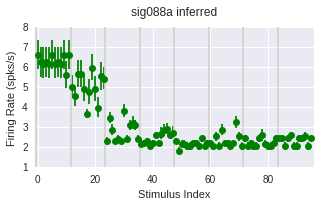

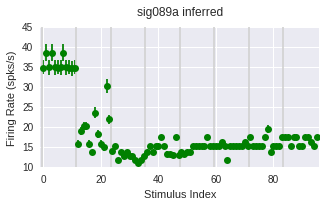

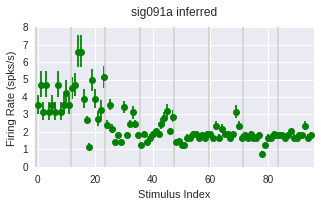

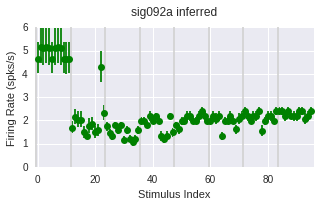

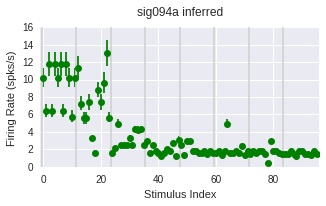

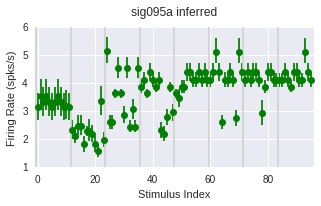

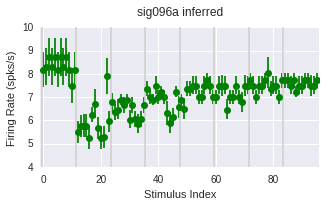

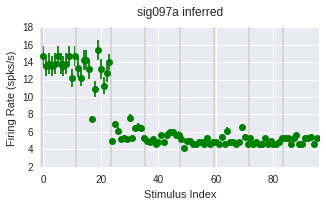

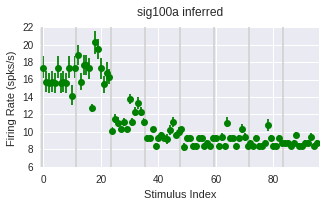

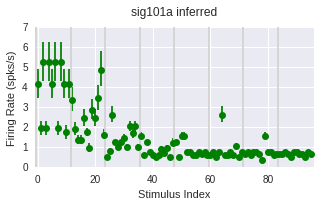

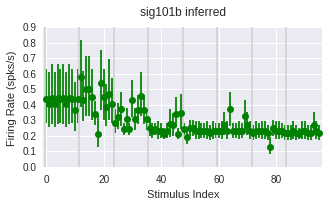

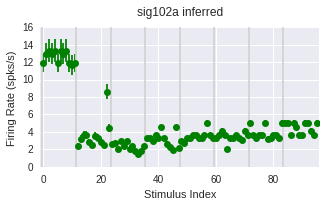

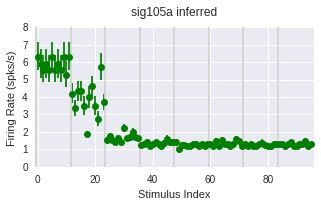

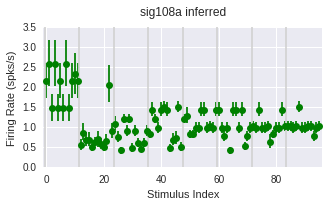

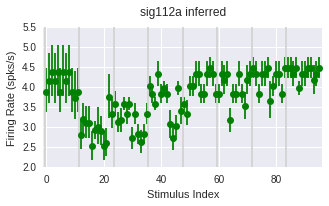

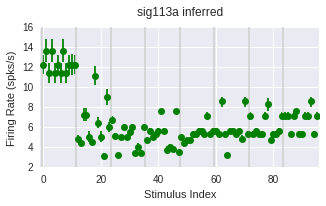

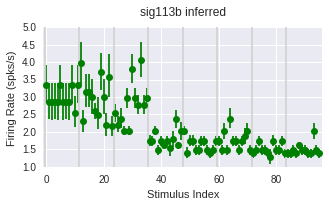

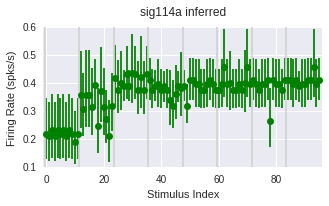

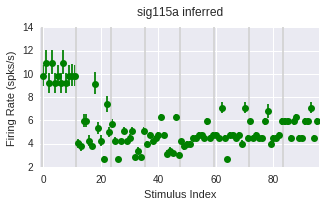

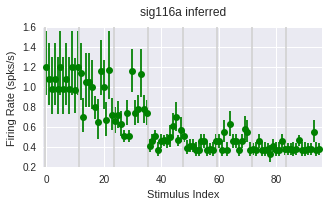

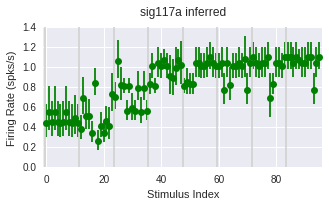

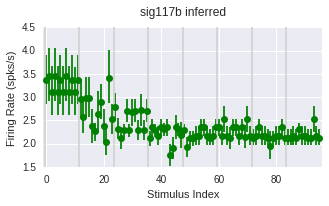

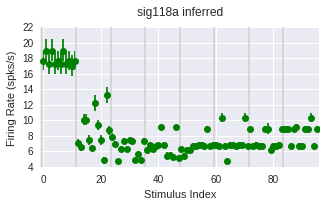

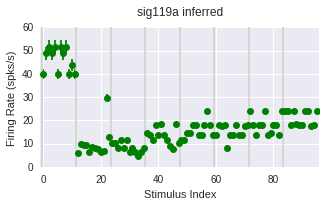

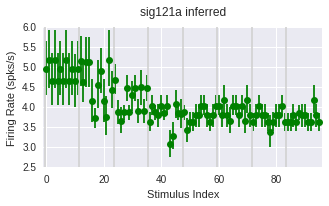

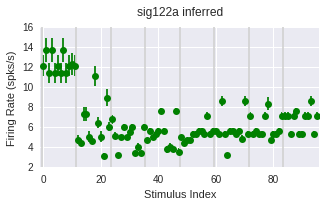

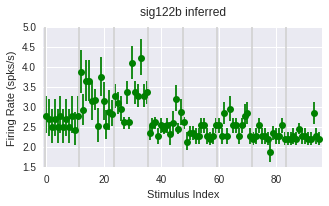

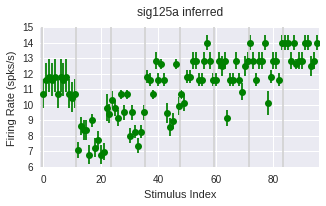

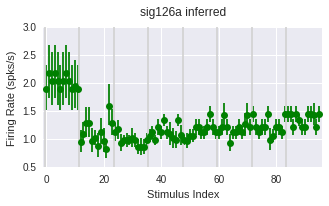

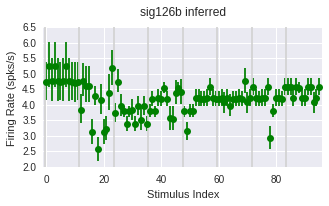

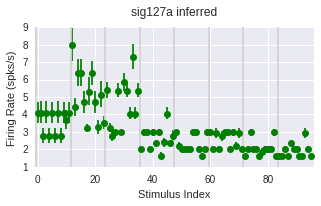

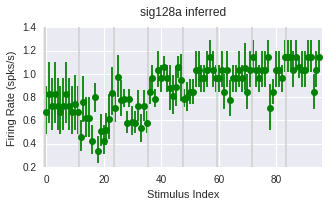

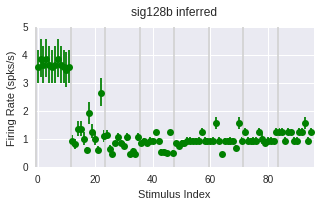

In [21]:
# plot figures from all stats


if savefig:
    # print to pdf using PdfPages
    pp = PdfPages('spikecount_simulations.pdf')
    sns.set_context('talk', font_scale=1.5)
    sns.set_style('white')
    
# Draw pics from simulations
for unit in range(Nu):
    plt.figure(figsize=(5, 2.5))
    plt.title(snames[unit] + ' inferred', y=1.05)
    
    x = np.arange(0, allstats.shape[1], 1)
    y = allstats[unit, :, 0]
    
    for ind in range(0, Nstim, 12):
        plt.axvline(ind - 0.5, color='lightgrey')
    plt.vlines(x, allstats[unit, :, 1], allstats[unit, :, 2], colors='green')
    plt.plot(y, 'go')

    plt.xlim([-1, allstats.shape[1]])
    # plt.ylim([5, 45])
    plt.ylabel('Firing Rate (spks/s)')
    plt.xlabel('Stimulus Index')
    
    if savefig:
        pp.savefig()

if savefig:
    pp.close()

## Weight categories by effect sizes

First, get mean effect size for each firing rate effect:

We have
$$
\lambda_u \sim \mathrm{Ga}(c, c\theta)
$$
so 
$$
\mathbb{E}[\lambda_u] = \mathbb{E}\left[\frac{c}{c\theta}\right] = \mathbb{E}[\theta^{-1}] = \frac{r_\theta}{s_\theta - 1}
$$
where $r_\theta$ and $s_\theta$ are the rate and shape parameters for $\theta$, respectively.

In [22]:
th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

effsize = th_pars[1] / (th_pars[0] - 1)  # mean of posterior for mean effect size

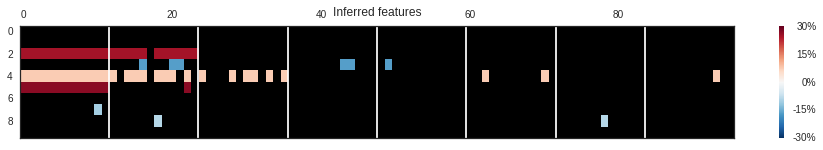

In [23]:
X = (effsize ** xi[bin_stim::bins]).T
X[(np.abs(X) < 5e-4) | (np.abs(X - 1) < 5e-2)] = np.nan

with sns.axes_style("white"):
    plt.figure(figsize=(20, 8))
    ax = plt.matshow(X, aspect='auto', cmap=cmap, norm=norm);

plt.title('Inferred features')
for ind in range(0, xi.shape[0] // bins, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='white')
cbar = plt.colorbar();
cbar.set_ticks([.7, .85, 1, 1.15, 1.3])
cbar.set_ticklabels(['-30%', '-15%', '0%', '15%', '30%'])

for t in cbar.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(5.5)

## Make $\xi$ dataframe:

In [24]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

In [25]:
bl = gpm.nodes['baseline']
unit_baseline_means = bl.expected_x() / dt

/home/xinchen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:1877: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._random_state.standard_gamma(a, self._size)
/home/xinchen/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


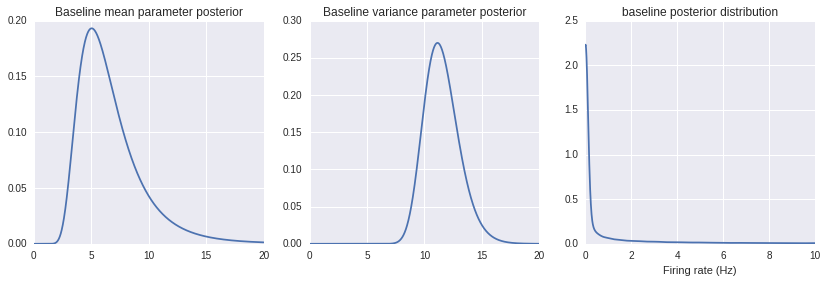

In [26]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 20, 1000)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 1000)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 10);

## Regressors

In [27]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

In [28]:
frn = gpm.nodes['fr_latents']
fr_mean_effect = frn.expected_x()

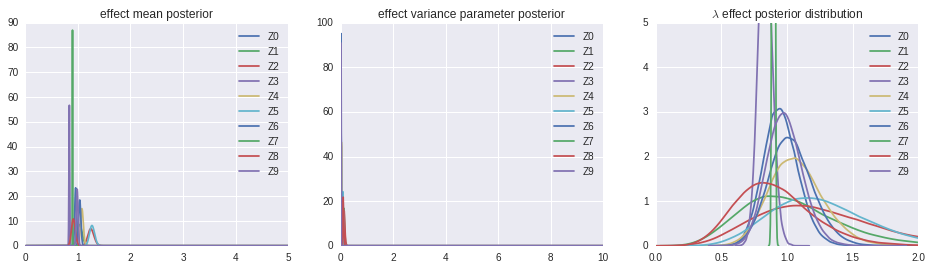

In [29]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5, 1000)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 10, 1000)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    #print(samples)
    if not np.any(samples):
        print(kk)
        continue
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

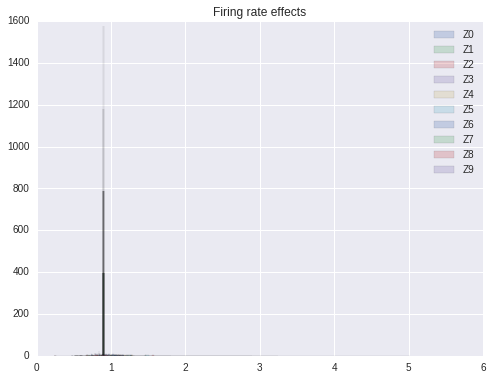

In [30]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
#plt.ylim(0, 5);

In [31]:
inferred_effects[4]

array([ 0.93645703,  0.693985  ,  1.26874312,  0.85655921,  1.05129141,
        1.28646613,  1.07350379,  0.8979806 ,  0.95504604,  1.02364423])

## Sparsity

In [32]:
if 'fr_latents_feature' in gpm.nodes:
    matshow(gpm.nodes['fr_latents_feature'].expected_x().T)

    gpm.nodes['fr_latents_sparsity'].expected_x()[0]

## Overdispersion

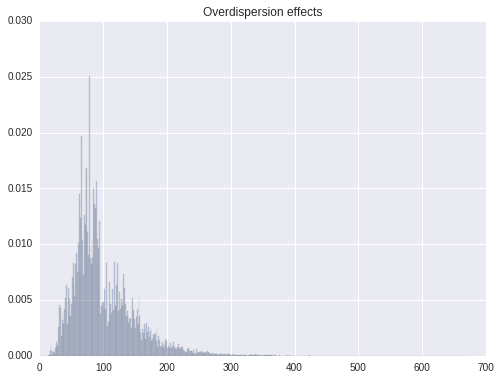

In [33]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, .03);

## Overdispersion in natural time

In [34]:
if gpm.overdispersion_natural:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion_natural'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 7);

# Load and prepare coded features:

In [35]:
df.head()

,trial,unit,count,category,time
0,69,0,2,Baseline,0
1,69,1,1,Baseline,0
2,69,2,2,Baseline,0
3,69,3,0,Baseline,0
4,69,4,3,Baseline,0


In [36]:
df2 = df.copy()
df2['value'] = 1
df2 = df2.drop(['trial', 'unit'], axis=1).drop_duplicates()
catdf = pd.pivot_table(df2, values='value', index=['time'], columns=['category']).reset_index().fillna(0)
catdf.columns.name = ''

In [37]:
edf = pd.merge(catdf, xif).sort_values(by='time').drop(['time', 'Baseline'], axis=1)

# View results:

In [38]:
savefig = True

In [39]:
categories = ['Faces', 'Animals', 'Bodies', 'Fruit', 'Natural', 'Manmade', 'Scene', 'Pattern']
features = []
for i in range(10):
    features.append("Feature {}".format(i))

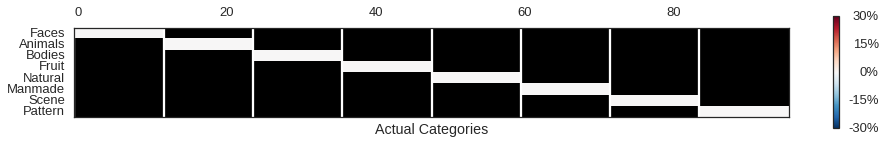

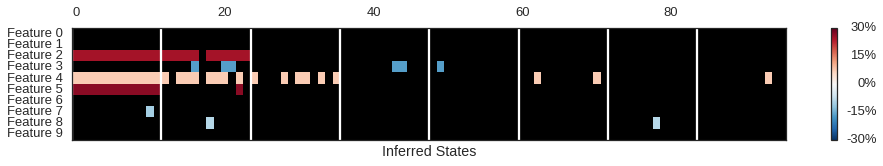

In [40]:

X[np.abs(X - 1) < 5e-2] = np.nan
cat = pd.DataFrame.as_matrix(catdf.iloc[1::3][categories]).T
cat[cat < 5e-2] = np.nan

if savefig:
    sns.set_context('talk')
    sns.set_style('white')

# show category
with sns.axes_style("white"):
    ax = plt.matshow(cat, aspect=1.5, cmap=cmap, norm=norm);

for ind in range(0, xi.shape[0] // bins, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='white')
plt.xlabel('Actual Categories')
plt.yticks(xrange(len(categories)), categories)
cbar = plt.colorbar()
cbar.set_ticks([.7, .85, 1, 1.15, 1.3])
cbar.set_ticklabels(['-30%', '-15%', '0%', '15%', '30%'])
for t in cbar.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(6.5)

if savefig:
    plt.savefig("imgclust_actual.svg", format="svg", bbox_inches='tight')
    sns.set()
    sns.set_context('talk')
    sns.set_style('white')
    
# show inferred states
with sns.axes_style("white"):
    ax = plt.matshow(X, aspect='auto', cmap=cmap, norm=norm);

for ind in range(0, xi.shape[0] // bins, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='white')
plt.xlabel('Inferred States')
plt.yticks(xrange(len(features)), features)

cbar = plt.colorbar();
cbar.set_ticks([.7, .85, 1, 1.15, 1.3])
cbar.set_ticklabels(['-30%', '-15%', '0%', '15%', '30%'])

for t in cbar.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(6.5)

if savefig:
    plt.savefig('imgclust_inferred.svg', format="svg", bbox_inches='tight')
    sns.set()


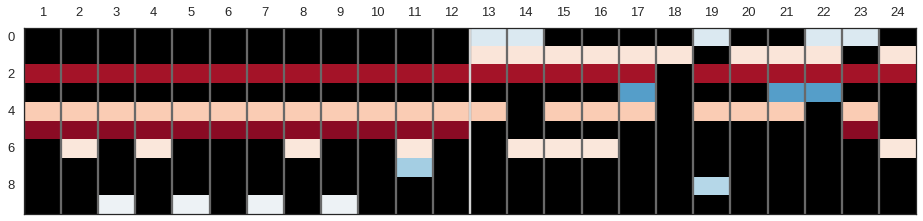

In [41]:
if savefig:
    sns.set_context('talk')
    sns.set_style('white')

Y = (effsize ** xi[bin_stim::bins]).T
Y[np.abs(Y - 1) < 1e-2] = np.nan

with sns.axes_style("white"):
    ax = plt.figure(figsize=(20, 8))
    frame = plt.matshow(Y[:, :24], aspect=.5, cmap=cmap, norm=norm)

for ind in range(0, 24):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='dimgrey')

plt.axvline(11.5, 0, xi.shape[-1], color='lightgrey')
plt.xticks(xrange(24), xrange(1, 25))

if savefig:
    plt.savefig('imgclust_2cat.svg', format="svg", bbox_inches='tight')
    sns.set()

In [42]:
effsize

array([ 0.95636995,  1.0357123 ,  1.24851979,  0.83503057,  1.07617735,
        1.26994797,  1.03421468,  0.89766823,  0.91450091,  0.98565668])

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [43]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

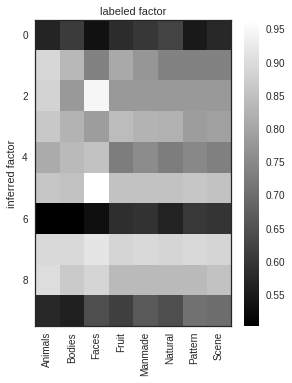

In [44]:
row_labels = edf.columns[:-K]
matshow(overlap.values[-K:,:-K]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

## Mutual Information

In [45]:
mi_mat = mutual_information_matrix(edf.iloc[:, :-K].values, edf.iloc[:, -K:].values)

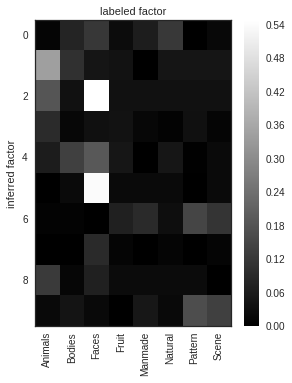

In [46]:
row_labels = edf.columns[:-K]
matshow(mi_mat.T, vmin=0, vmax=0.55)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');